In [1]:
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import env
from pydataset import data
from scipy.stats import pearsonr, spearmanr
import scipy
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import explained_variance_score
import statsmodels.api as sm
import acquire
import prepare

# Scenario
You are a junior data scientist on the Zillow data science team and recieve the following email in your inbox:

We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.

-- The Zillow Data Science Team



# Goals 
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?

- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in prediction these homes' values.

# Acquiring the Data

- Information on aquiring the data can be seen in [Github.Acquire_code](https://github.com/EribertoContreras/zillow_estimating_home_value/blob/main/acquire.py), an individual with the correct credentials can repeat the process of acquiring the data and get the same results when calling on the data by using the next 3 lines of code on this jupyter notebook

In [2]:
# retrive original data set from aquire.py 
df = acquire.get_zillow_data()

In [3]:
#original shape of combined (Properties_2017, Predictions_2017, Propertylandusetype) from zillow data set.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52442 non-null  float64
 1   parcelid                      52442 non-null  int64  
 2   id                            52442 non-null  int64  
 3   airconditioningtypeid         13638 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   basementsqft                  47 non-null     float64
 6   bathroomcnt                   52442 non-null  float64
 7   bedroomcnt                    52442 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         33741 non-null  float64
 10  calculatedbathnbr             52305 non-null  float64
 11  decktypeid                    389 non-null    float64
 12  finishedfloor1squarefeet      4381 non-null   float64
 13  c

# Preparing The Data

[Github.Cleaning_data_code](https://github.com/EribertoContreras/zillow_estimating_home_value/blob/main/prepare.py)

In [4]:
df = prepare.clean_zillow_data(df)

In [5]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
count,41778.000000,41778.000000,41778.000000,41778.000000,4.177800e+04,4.177800e+04,41778.000000,41778.000000,41778.000000,41778.000000
mean,2.046699,3.174925,1633.332639,6049.238403,3.403123e+07,-1.181876e+08,2526.326727,96607.597563,1962.533080,351912.760640
std,0.655959,0.762033,529.405327,21.212097,2.758422e+05,3.551690e+05,802.232330,3921.575967,19.927343,223528.131146
min,1.000000,2.000000,500.000000,6037.000000,3.334062e+07,-1.194753e+08,1286.000000,0.000000,1920.000000,3254.000000
25%,2.000000,3.000000,1230.000000,6037.000000,3.383392e+07,-1.183834e+08,1286.000000,96218.000000,1951.000000,165842.500000
50%,2.000000,3.000000,1542.000000,6037.000000,3.401303e+07,-1.181314e+08,3101.000000,96437.000000,1959.000000,323580.500000
75%,2.500000,4.000000,1974.000000,6059.000000,3.419903e+07,-1.179334e+08,3101.000000,97005.000000,1976.000000,495135.750000
max,3.500000,5.000000,3049.000000,6111.000000,3.481877e+07,-1.175546e+08,3101.000000,399675.000000,2015.000000,999900.000000


In [6]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,2061.0,97099.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,1286.0,97078.0,1962.0,564778.0
3,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,3101.0,96330.0,1970.0,145143.0
4,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,3101.0,96293.0,1950.0,773303.0
5,1.0,2.0,738.0,6037.0,34149214.0,-118239357.0,3101.0,96325.0,1922.0,218552.0
...,...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,3101.0,96284.0,1940.0,354621.0
52438,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,2061.0,97116.0,1964.0,67205.0
52439,1.0,3.0,1032.0,6037.0,34040895.0,-118038169.0,3101.0,96480.0,1954.0,49546.0
52440,2.0,3.0,1762.0,6037.0,33937685.0,-117996709.0,3101.0,96171.0,1955.0,522000.0


In [7]:
df.shape

(41778, 10)

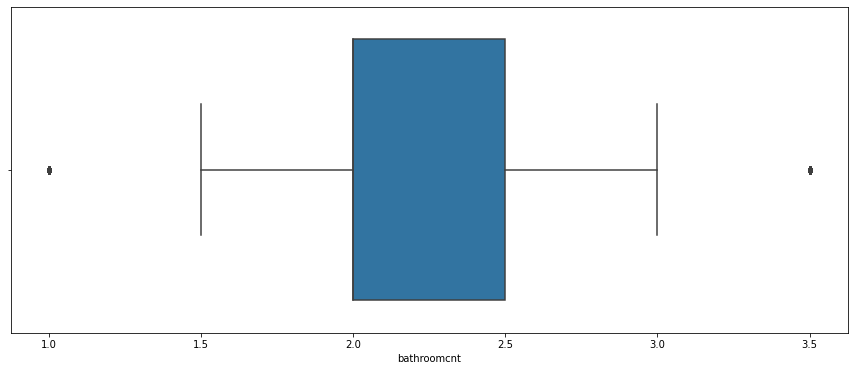

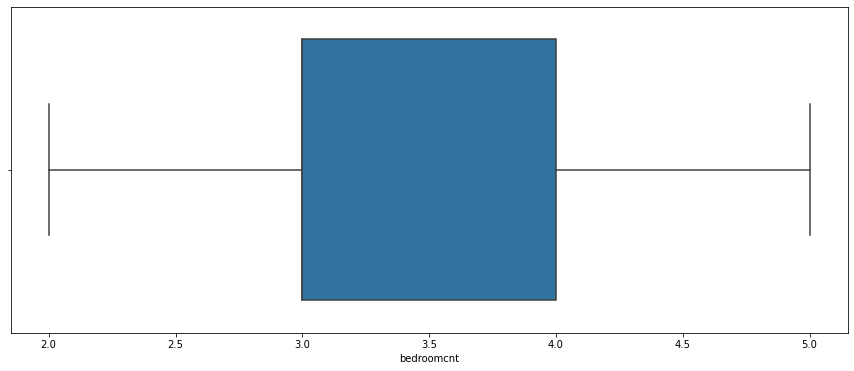

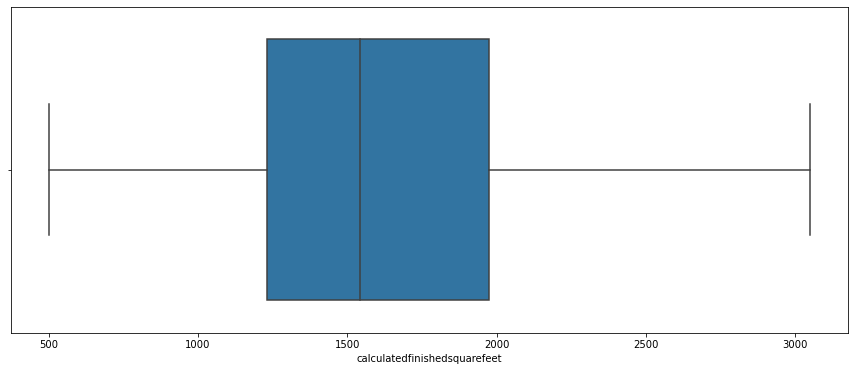

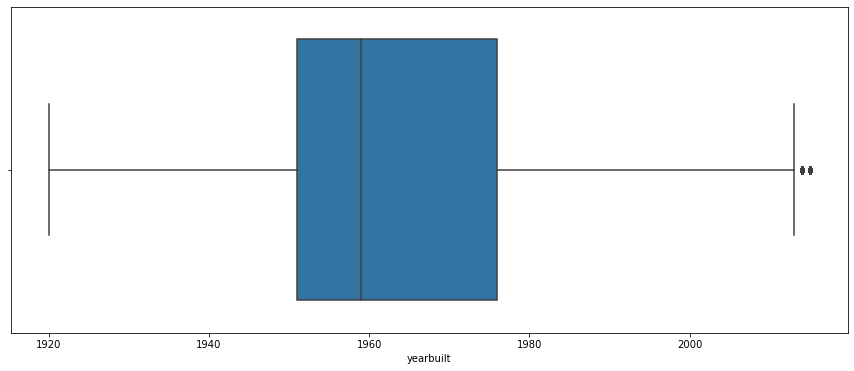

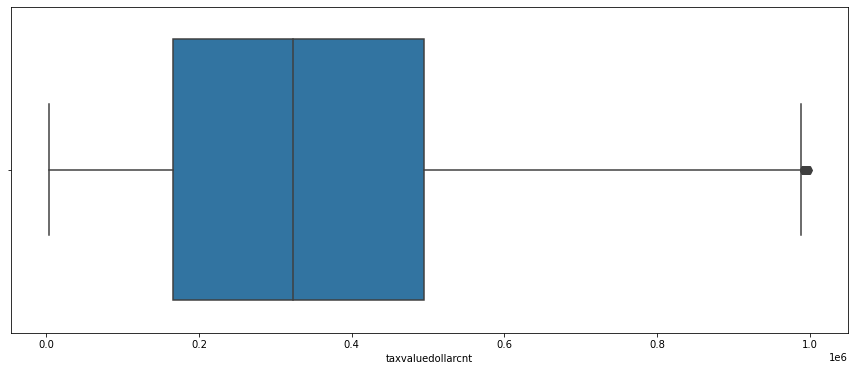

In [8]:
for column in ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt']:
    plt.figure(figsize=(15,6))
    sns.boxplot(x=column, data=df)
    plt.show()

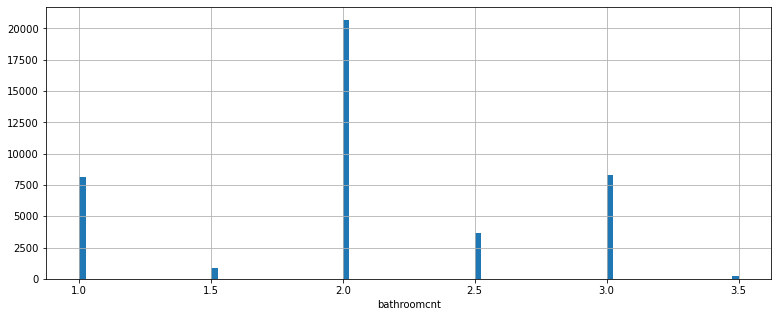

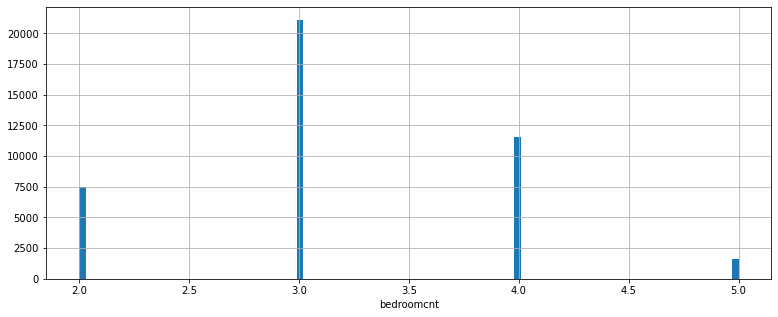

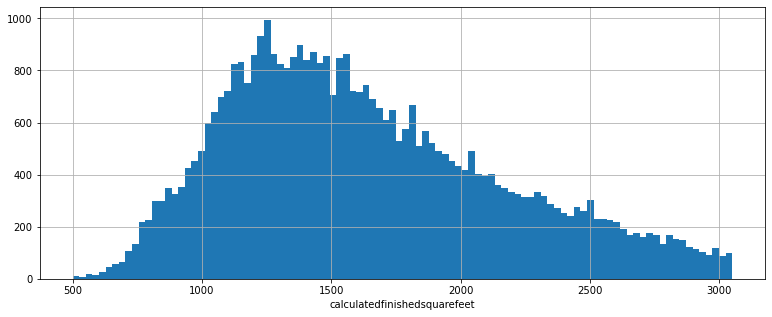

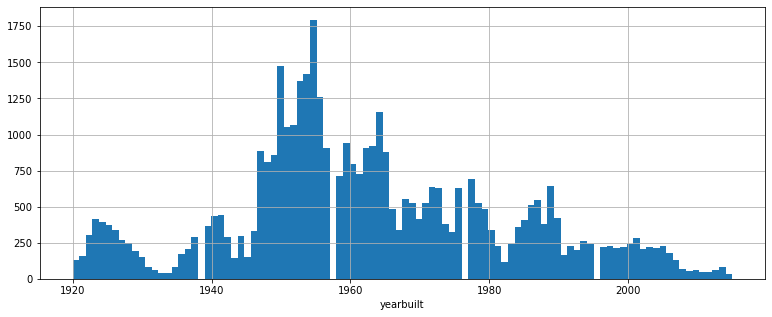

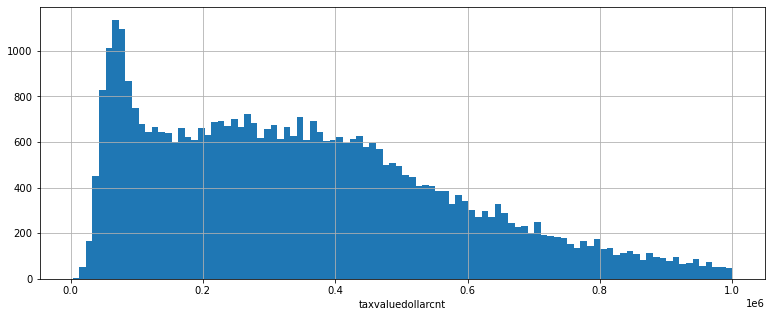

In [9]:
for column in ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt']:
    plt.figure(figsize=(13,5))
    df[column].hist(bins=100)
    plt.xlabel(column)
    plt.show()

In [10]:
df[df.taxvaluedollarcnt > 1000000]

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt


In [11]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,2061.0,97099.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,1286.0,97078.0,1962.0,564778.0
3,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,3101.0,96330.0,1970.0,145143.0
4,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,3101.0,96293.0,1950.0,773303.0
5,1.0,2.0,738.0,6037.0,34149214.0,-118239357.0,3101.0,96325.0,1922.0,218552.0
...,...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,3101.0,96284.0,1940.0,354621.0
52438,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,2061.0,97116.0,1964.0,67205.0
52439,1.0,3.0,1032.0,6037.0,34040895.0,-118038169.0,3101.0,96480.0,1954.0,49546.0
52440,2.0,3.0,1762.0,6037.0,33937685.0,-117996709.0,3101.0,96171.0,1955.0,522000.0


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

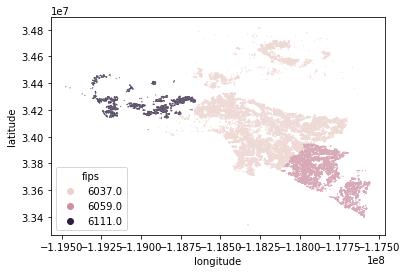

In [12]:
sns.scatterplot(df.longitude, df.latitude, s=1, hue= df.fips)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

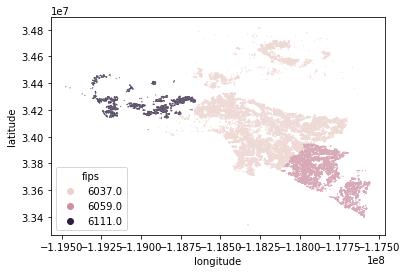

In [13]:
sns.scatterplot(df.longitude, df.latitude, s=1, hue= df.fips)

# Area of ventura county

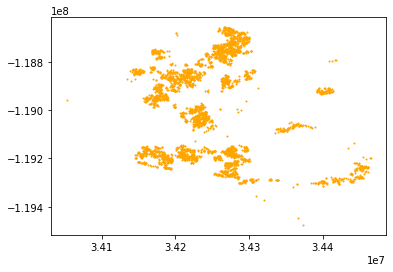

In [14]:
ventura = df[df.fips == 6111.0]
plt.scatter(ventura.latitude, ventura.longitude, s=1, c='orange')


# Area of Los Angeles county

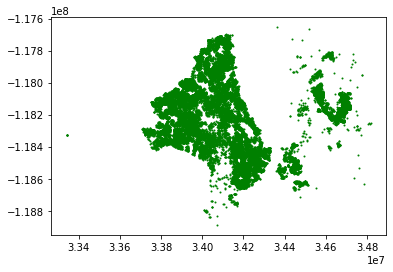

In [15]:
la = df[df.fips == 6037.0]
plt.scatter(la.latitude, la.longitude, s=1,c='green')

# Area of Orange county

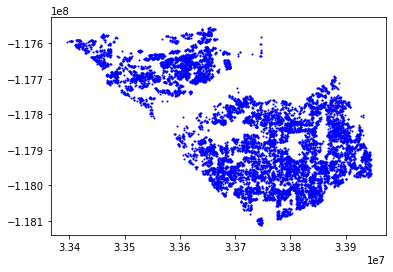

In [16]:
oc = df[df.fips == 6059.0]
plt.scatter(oc.latitude, oc.longitude, s=1,c='b')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41778 entries, 1 to 52441
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   41778 non-null  float64
 1   bedroomcnt                    41778 non-null  float64
 2   calculatedfinishedsquarefeet  41778 non-null  float64
 3   fips                          41778 non-null  float64
 4   latitude                      41778 non-null  float64
 5   longitude                     41778 non-null  float64
 6   regionidcounty                41778 non-null  float64
 7   regionidzip                   41778 non-null  float64
 8   yearbuilt                     41778 non-null  float64
 9   taxvaluedollarcnt             41778 non-null  float64
dtypes: float64(10)
memory usage: 3.5 MB


In [18]:
#Spliting my data
train, validate, test = prepare.split_zillow_data(df)

# Scaling CalculatedFinishedSquarefeet

In [19]:
print('train shape: %d x %d' % train.shape)
print('test shape: %d x %d' % test.shape)
train.head()

train shape: 23395 x 10
test shape: 8356 x 10


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
32026,3.0,4.0,2322.0,6111.0,34217270.0,-118833792.0,2061.0,96385.0,1994.0,816000.0
25538,2.0,2.0,1169.0,6059.0,33875104.0,-117759734.0,1286.0,97079.0,1984.0,426366.0
25855,2.5,4.0,2722.0,6059.0,33700114.0,-117974634.0,1286.0,97008.0,1970.0,112555.0
45069,1.0,3.0,1000.0,6037.0,34012604.0,-117909971.0,3101.0,96488.0,1958.0,115421.0
33891,3.0,3.0,1534.0,6037.0,34642073.0,-118231653.0,3101.0,97319.0,1968.0,246500.0


In [20]:
X_train = train[['calculatedfinishedsquarefeet']]
y_train = train['taxvaluedollarcnt']

X_validate = validate[['calculatedfinishedsquarefeet']]
y_validate = validate['taxvaluedollarcnt']

X_test = test[['calculatedfinishedsquarefeet']]
y_test = test['taxvaluedollarcnt']

In [21]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test, return_scaler=True)

Text(0.5, 1.0, 'Scaled')

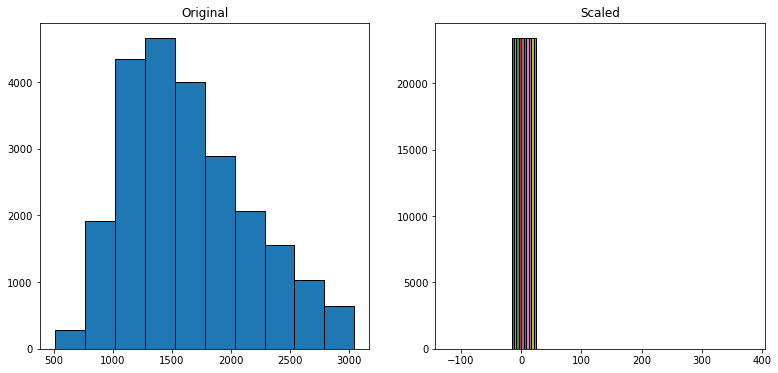

In [22]:
scaler = sklearn.preprocessing.RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(train)

x_train_scaled = scaler.transform(train)
x_validate_scaled = scaler.transform(validate)
x_test_scaled = scaler.transform(test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=10, ec='black')
plt.title('Scaled')

# DATA EXPLORATION

## Working on Our Most Valuable Payers that affect TaxValueDollarCount

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23395 entries, 32026 to 10442
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   23395 non-null  float64
 1   bedroomcnt                    23395 non-null  float64
 2   calculatedfinishedsquarefeet  23395 non-null  float64
 3   fips                          23395 non-null  float64
 4   latitude                      23395 non-null  float64
 5   longitude                     23395 non-null  float64
 6   regionidcounty                23395 non-null  float64
 7   regionidzip                   23395 non-null  float64
 8   yearbuilt                     23395 non-null  float64
 9   taxvaluedollarcnt             23395 non-null  float64
dtypes: float64(10)
memory usage: 2.0 MB


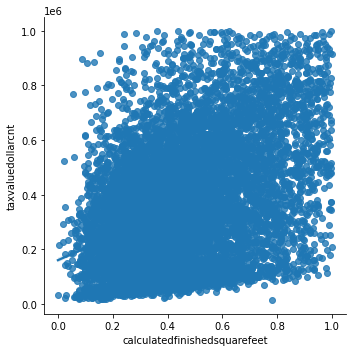

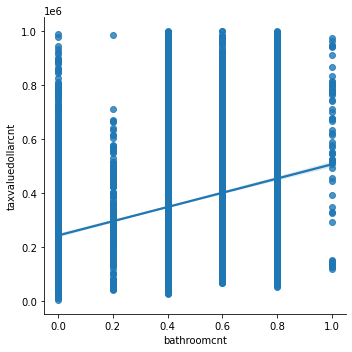

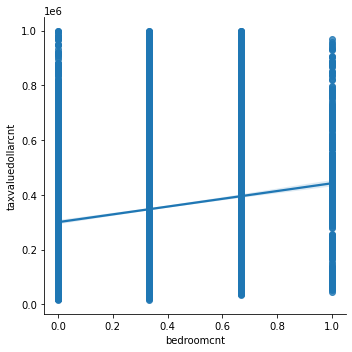

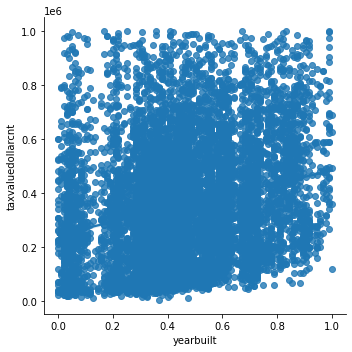

In [24]:
prepare.plot_variable_pairs(train_scaled)

<AxesSubplot:xlabel='bathroomcnt', ylabel='taxvaluedollarcnt'>

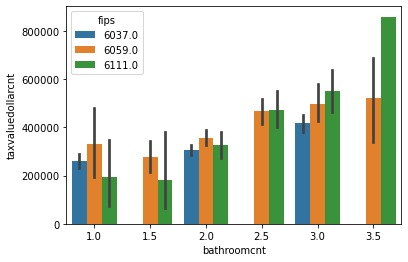

In [25]:
sns.barplot(x = 'bathroomcnt', y='taxvaluedollarcnt', hue = 'fips',data=train.sample(1000))

<AxesSubplot:>

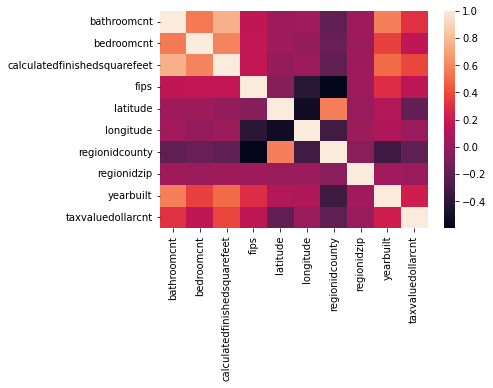

In [26]:
sns.heatmap(train.corr())

Text(0.5, 1.0, 'Distribution of Tax Rates')

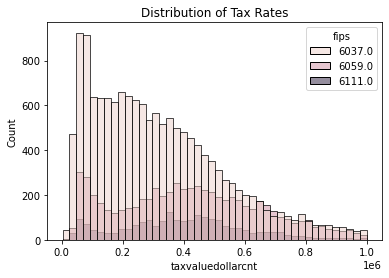

In [27]:
sns.histplot(data=train, x="taxvaluedollarcnt", hue = 'fips')
plt.title('Distribution of Tax Rates')

In [28]:
train.describe()[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt','fips']]

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips
count,23395.000000,23395.000000,23395.000000,23395.000000,23395.000000
mean,2.052041,3.180851,1634.782945,352930.963283,6049.535414
std,0.653931,0.760828,526.672968,223570.289892,21.454284
min,1.000000,2.000000,504.000000,3254.000000,6037.000000
25%,2.000000,3.000000,1233.000000,165683.000000,6037.000000
50%,2.000000,3.000000,1548.000000,326331.000000,6037.000000
75%,2.500000,4.000000,1974.000000,495436.500000,6059.000000
max,3.500000,5.000000,3049.000000,999900.000000,6111.000000


- Calculatedfinishedsqaurefeet has a large differance that has a significant affect on TaxValuedollarcount
- Bathroomcnt has a differance that has a moderate significant affect on TaxValuedollarcount
- Bedroomcnt has a differance that has a moderate significant affect on TaxValuedollarcount

well be focusing on calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt

# Hypothesis testing

In [29]:
alpha = 0.05

In [30]:
# corralation with sq ft and tax value dollar count
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
corr, p

(0.3821382331108312, 0.0)

In [31]:
p < alpha

True

In [32]:
train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
count,23395.000000,23395.000000,23395.000000,23395.000000,2.339500e+04,2.339500e+04,23395.000000,23395.000000,23395.000000,23395.000000
mean,2.052041,3.180851,1634.782945,6049.535414,3.402932e+07,-1.181886e+08,2516.497328,96623.478307,1962.717418,352930.963283
std,0.653931,0.760828,526.672968,21.454284,2.761347e+05,3.579537e+05,804.798273,4753.893856,19.882080,223570.289892
min,1.000000,2.000000,504.000000,6037.000000,3.334085e+07,-1.193551e+08,1286.000000,0.000000,1920.000000,3254.000000
25%,2.000000,3.000000,1233.000000,6037.000000,3.382947e+07,-1.183843e+08,1286.000000,96218.000000,1951.000000,165683.000000
50%,2.000000,3.000000,1548.000000,6037.000000,3.401066e+07,-1.181302e+08,3101.000000,96438.000000,1960.000000,326331.000000
75%,2.500000,4.000000,1974.000000,6059.000000,3.419834e+07,-1.179343e+08,3101.000000,97005.000000,1976.000000,495436.500000
max,3.500000,5.000000,3049.000000,6111.000000,3.481877e+07,-1.175546e+08,3101.000000,399675.000000,2015.000000,999900.000000


***

In [33]:
zillow_corr = train.drop(columns=['taxvaluedollarcnt']).corr()
zillow_corr


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt
bathroomcnt,1.000000,0.554232,0.757832,0.155995,0.029156,0.039002,-0.202624,0.030716,0.569255
bedroomcnt,0.554232,1.000000,0.589895,0.161480,0.032478,0.000724,-0.161593,0.018171,0.362715
calculatedfinishedsquarefeet,0.757832,0.589895,1.000000,0.164643,0.000050,0.022756,-0.203517,0.032189,0.503467
fips,0.155995,0.161480,0.164643,1.000000,-0.056976,-0.419089,-0.598488,0.036344,0.291453
latitude,0.029156,0.032478,0.000050,-0.056976,1.000000,-0.528045,0.571256,0.011682,0.105946
longitude,0.039002,0.000724,0.022756,-0.419089,-0.528045,1.000000,-0.329304,0.025028,0.089572
regionidcounty,-0.202624,-0.161593,-0.203517,-0.598488,0.571256,-0.329304,1.000000,-0.042987,-0.330767
regionidzip,0.030716,0.018171,0.032189,0.036344,0.011682,0.025028,-0.042987,1.000000,0.040436
yearbuilt,0.569255,0.362715,0.503467,0.291453,0.105946,0.089572,-0.330767,0.040436,1.000000


# Evaluating regression models

In [34]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(train.taxvaluedollarcnt)
X = pd.DataFrame(train.calculatedfinishedsquarefeet)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)
train

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,yhat
32026,3.0,4.0,2322.0,6111.0,34217270.0,-118833792.0,2061.0,96385.0,1994.0,816000.0,464408.530276
25538,2.0,2.0,1169.0,6059.0,33875104.0,-117759734.0,1286.0,97079.0,1984.0,426366.0,277373.540644
25855,2.5,4.0,2722.0,6059.0,33700114.0,-117974634.0,1286.0,97008.0,1970.0,112555.0,529294.910026
45069,1.0,3.0,1000.0,6037.0,34012604.0,-117909971.0,3101.0,96488.0,1958.0,115421.0,249959.045199
33891,3.0,3.0,1534.0,6037.0,34642073.0,-118231653.0,3101.0,97319.0,1968.0,246500.0,336582.362167
...,...,...,...,...,...,...,...,...,...,...,...
43614,2.0,4.0,1354.0,6111.0,34266855.0,-119183007.0,2061.0,97084.0,1964.0,285614.0,307383.491279
36173,3.0,3.0,2320.0,6037.0,34085457.0,-118267232.0,3101.0,96007.0,1963.0,944002.0,464084.098377
4002,1.0,3.0,1036.0,6037.0,33938921.0,-118198030.0,3101.0,96125.0,1939.0,48209.0,255798.819377
19520,3.0,4.0,1670.0,6037.0,34447844.0,-118519290.0,3101.0,96373.0,1982.0,273659.0,358643.731282


In [35]:
df = pd.DataFrame(train[['calculatedfinishedsquarefeet','taxvaluedollarcnt','yhat']])
df.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,yhat
32026,2322.0,816000.0,464408.530276
25538,1169.0,426366.0,277373.540644
25855,2722.0,112555.0,529294.910026
45069,1000.0,115421.0,249959.045199
33891,1534.0,246500.0,336582.362167


In [75]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.taxvaluedollarcnt.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.taxvaluedollarcnt - df.yhat
df['baseline_residual'] = df.taxvaluedollarcnt - df.baseline

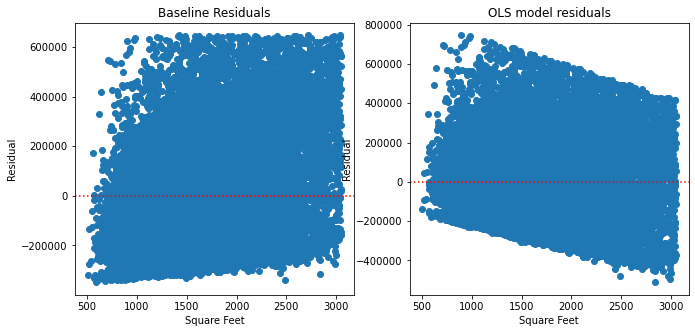

In [76]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(df.calculatedfinishedsquarefeet, df.baseline_residual)
plt.axhline(y = 0, ls = ':', color='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(df.calculatedfinishedsquarefeet, df.residual)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals');


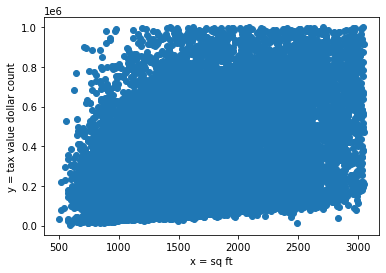

In [77]:
y = pd.DataFrame(df.taxvaluedollarcnt)
X = pd.DataFrame(df.calculatedfinishedsquarefeet)
# look at scatter of x vs y
plt.scatter(X, y)
plt.xlabel('x = sq ft')
plt.ylabel('y = tax value dollar count');

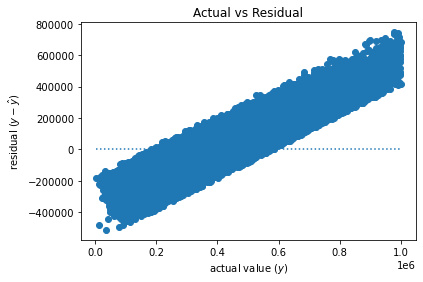

In [78]:
# Residual plot (y vs residual)
actual = df.taxvaluedollarcnt
predicted = df.yhat
residuals = actual - predicted
plt.hlines(0, actual.min(), actual.max(), ls=':')
plt.scatter(actual, residuals)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title('Actual vs Residual')
plt.show()


In [79]:
# sum of residual is zero
df.residual.sum()

8.642673492431641e-07

In [80]:
# sum of baseline residual is zero too
df.baseline_residual.sum()

22536.0

In [81]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
32026,2322.0,816000.0,464408.530276,352930,351591.469724,463070.0,1.236166e+11,2.144338e+11
25538,1169.0,426366.0,277373.540644,352930,148992.459356,73436.0,2.219875e+10,5.392846e+09
25855,2722.0,112555.0,529294.910026,352930,-416739.910026,-240375.0,1.736722e+11,5.778014e+10
45069,1000.0,115421.0,249959.045199,352930,-134538.045199,-237509.0,1.810049e+10,5.641053e+10
33891,1534.0,246500.0,336582.362167,352930,-90082.362167,-106430.0,8.114832e+09,1.132734e+10


In [82]:
SSE = df['residual^2'].sum()
SSE_baseline = df['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

if SSE < SSE_baseline:
    print('SSE is better than baseline')
else:
    print('baseline is better')

SSE = 998562995872140.0
SSE Baseline = 1169318081798494.0
SSE is better than baseline


In [83]:
len(df)
df.shape[0]

23395

In [84]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

MSE =  42682752548.5
MSE baseline =  49981538012.3
MSE is better than baseline


In [85]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE is better than baseline
RMSE =  206598.0
RMSE baseline =  223565.5


In [86]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

OLS regression model performs better than the baseline


In [87]:
# sklearn.metrics.explained_variance_score

evs = explained_variance_score(df.taxvaluedollarcnt, df.yhat)
print('Explained Variance = ', round(evs,3))


Explained Variance =  0.146


In [88]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.taxvaluedollarcnt, df.yhat)

0.14602962920506812

In [89]:
X2 = sm.add_constant(df.calculatedfinishedsquarefeet)
est = sm.OLS(df.taxvaluedollarcnt, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     4000.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:38:26   Log-Likelihood:            -3.1952e+05
No. Observations:               23395   AIC:                         6.390e+05
Df Residuals:                   23393   BIC:                         6.391e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [90]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 score
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)
#_____________________________________________________________________________________
def regression_errors(actual, predicted):
    return pd.Series({
        'SSE': sse(actual, predicted),
        'ESS': ess(actual, predicted),
        'TSS': tss(actual),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
        'SSE': sse(actual, predicted),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [91]:
regression_errors(actual,predicted)

SSE     9.985630e+14
ESS     1.707551e+14
TSS     1.169318e+15
MSE     4.268275e+10
RMSE    2.065980e+05
dtype: float64

In [92]:
baseline_mean_errors(actual)

{'SSE': 1169318081776785.5,
 'MSE': 49981538011.40353,
 'RMSE': 223565.5116770105}

In [93]:
better_than_baseline(actual, predicted)

True

***

# Modeling

In [94]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [95]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.
y_train = pd.DataFrame(train.taxvaluedollarcnt)
y_validate = pd.DataFrame(validate.taxvaluedollarcnt)
# 1. Predict price_pred_mean
taxvaluedollarcnt_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
y_validate['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
# 2. compute price_pred_median
taxvaluedollarcnt_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
y_validate['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
# 4. RMSE of taxvaluedollarcnt_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  223565.51 
Validate/Out-of-Sample:  224163.45
RMSE using Median
Train/In-Sample:  225142.39 
Validate/Out-of-Sample:  225409.63


In [96]:

#predicting y from trained data
#predict rules
model = LinearRegression().fit(train_scaled, train.taxvaluedollarcnt)
predictions = model.predict(train_scaled)

In [58]:
y_test = pd.DataFrame(y_test)

y_test

,taxvaluedollarcnt
3058,442928.0
2537,210263.0
4867,582531.0
52441,259334.0
17827,264850.0
...,...
13122,280330.0
19031,265000.0
25924,354581.0
38548,401785.0


In [59]:
train_scaled

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
32026,0.8,0.666667,0.714342,6111.0,0.593010,0.289522,2061.0,0.241158,0.778947,816000.0
25538,0.4,0.000000,0.261297,6059.0,0.361491,0.886083,1286.0,0.242895,0.673684,426366.0
25855,0.6,0.666667,0.871513,6059.0,0.243088,0.766722,1286.0,0.242717,0.526316,112555.0
45069,0.0,0.333333,0.194892,6037.0,0.454527,0.802637,3101.0,0.241416,0.400000,115421.0
33891,0.8,0.333333,0.404715,6037.0,0.880444,0.623966,3101.0,0.243495,0.505263,246500.0
...,...,...,...,...,...,...,...,...,...,...
43614,0.4,0.666667,0.333988,6111.0,0.626561,0.095558,2061.0,0.242907,0.463158,285614.0
36173,0.8,0.333333,0.713556,6037.0,0.503822,0.604205,3101.0,0.240213,0.452632,944002.0
4002,0.0,0.333333,0.209037,6037.0,0.404671,0.642641,3101.0,0.240508,0.200000,48209.0
19520,0.8,0.666667,0.458153,6037.0,0.749023,0.464205,3101.0,0.241128,0.652632,273659.0


In [60]:
y_train.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean,taxvaluedollarcnt_pred_median
32026,816000.0,352930.963283,326331.0
25538,426366.0,352930.963283,326331.0
25855,112555.0,352930.963283,326331.0
45069,115421.0,352930.963283,326331.0
33891,246500.0,352930.963283,326331.0


# LinearRegression (ols)

In [61]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  206598.04584869446 
Validation/Out-of-Sample:  207918.4384651637


# LassoLars

In [62]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lars)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  206598.10246829293 
Validation/Out-of-Sample:  207916.3478186069


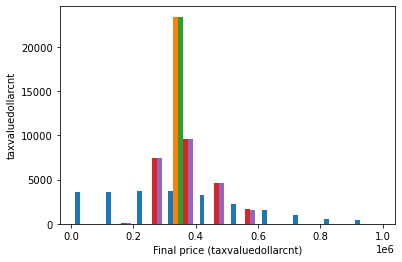

In [63]:
plt.hist(y_train)
plt.xlabel("Final price (taxvaluedollarcnt)")
plt.ylabel("taxvaluedollarcnt")
plt.show()


# TweedieRegressor (GLM)

In [64]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_glm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  223565.5116770105 
Validation/Out-of-Sample:  224163.45396943262


# Polynomial Regression

In [65]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [66]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm2)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  206567.70340974428 
Validation/Out-of-Sample:  207915.74865867087


In [67]:
y_test

,taxvaluedollarcnt
3058,442928.0
2537,210263.0
4867,582531.0
52441,259334.0
17827,264850.0
...,...
13122,280330.0
19031,265000.0
25924,354581.0
38548,401785.0


# evaluate

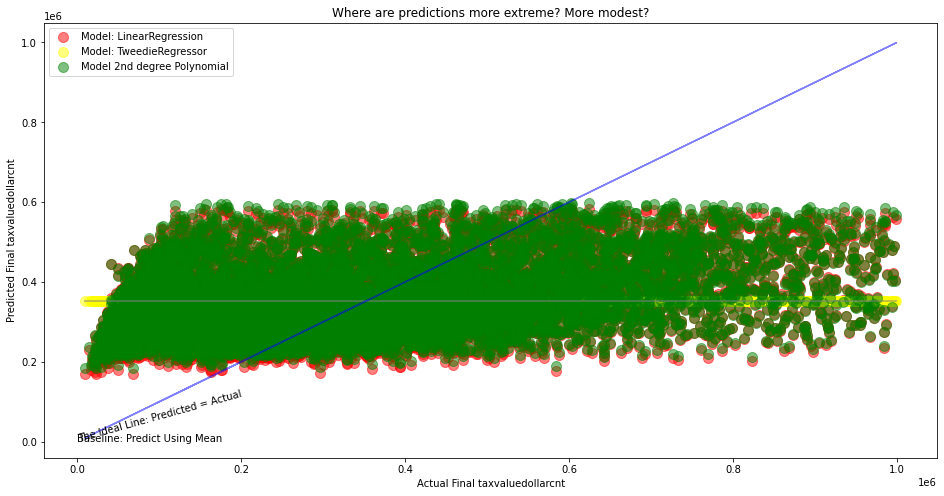

In [68]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final taxvaluedollarcnt")
plt.ylabel("Predicted Final taxvaluedollarcnt")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


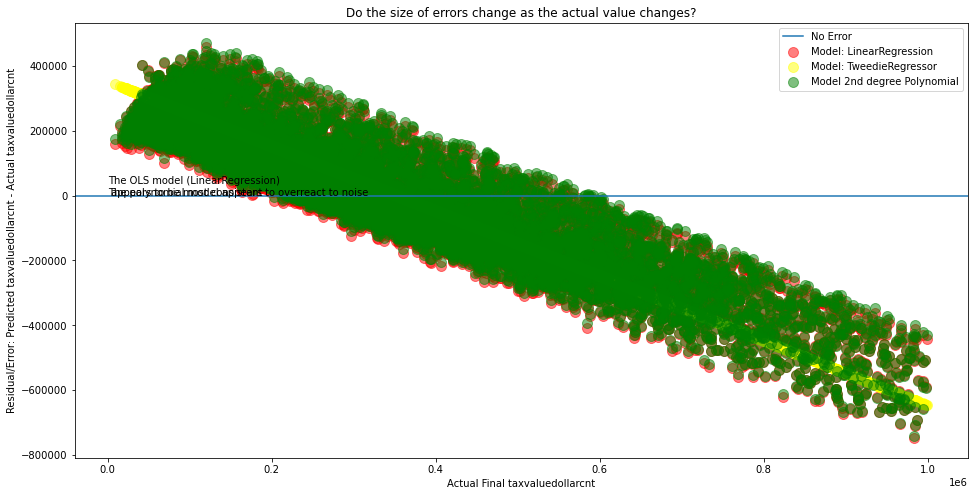

In [69]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final taxvaluedollarcnt")
plt.ylabel("Residual/Error: Predicted taxvaluedollarcnt - Actual taxvaluedollarcnt")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


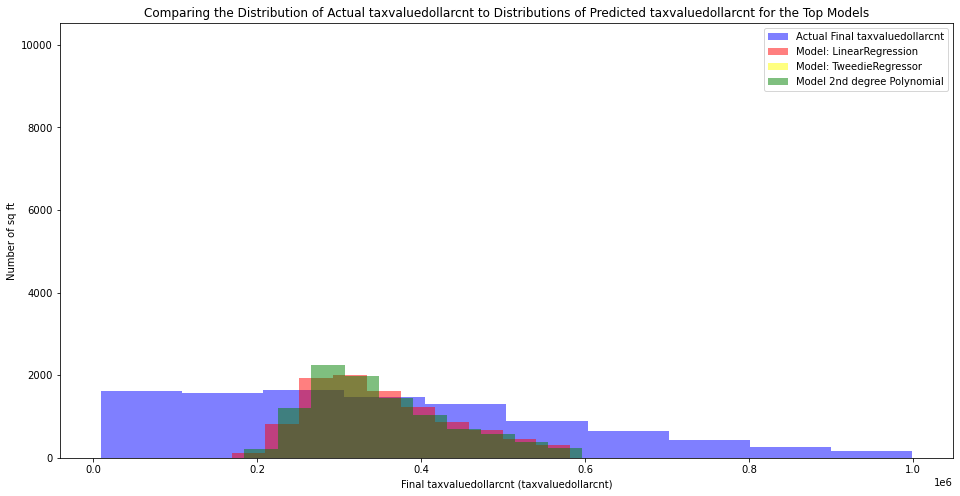

In [70]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Final taxvaluedollarcnt")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.taxvaluedollarcnt_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final taxvaluedollarcnt (taxvaluedollarcnt)")
plt.ylabel("Number of sq ft")
plt.title("Comparing the Distribution of Actual taxvaluedollarcnt to Distributions of Predicted taxvaluedollarcnt for the Top Models")
plt.legend()
plt.show()


In [71]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvaluedollarcnt_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvaluedollarcnt_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  204813.84376394577


In [72]:
y_train.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean,taxvaluedollarcnt_pred_median,taxvaluedollarcnt_pred_lm,taxvaluedollarcnt_pred_lars,taxvaluedollarcnt_pred_glm,taxvaluedollarcnt_pred_lm2
32026,816000.0,352930.963283,326331.0,464408.530276,464208.947202,352930.963283,464309.857652
25538,426366.0,352930.963283,326331.0,277373.540644,277508.814341,352930.963283,278236.353437
25855,112555.0,352930.963283,326331.0,529294.910026,528979.158081,352930.963283,535760.747469
45069,115421.0,352930.963283,326331.0,249959.045199,250143.400245,352930.963283,253443.715621
33891,246500.0,352930.963283,326331.0,336582.362167,336611.631769,352930.963283,333946.946772


In [73]:
y_validate.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean,taxvaluedollarcnt_pred_median,taxvaluedollarcnt_pred_lm,taxvaluedollarcnt_pred_lars,taxvaluedollarcnt_pred_glm,taxvaluedollarcnt_pred_lm2
7339,96721.0,352930.963283,326331.0,425152.270526,425022.969620,352930.963283,422807.297402
36772,390462.0,352930.963283,326331.0,324578.381913,324629.142756,352930.963283,322413.073627
29379,314996.0,352930.963283,326331.0,414770.449766,414659.735879,352930.963283,412048.882784
4029,57648.0,352930.963283,326331.0,251581.204693,251762.655517,352930.963283,254893.079572
32805,59811.0,352930.963283,326331.0,246228.078364,246419.113119,352930.963283,250118.606792


In [74]:
y_test.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_lm
3058,442928.0,343071.000142
2537,210263.0,363510.209763
4867,582531.0,534161.388508
52441,259334.0,258069.842668
17827,264850.0,372269.871030
